C:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\ml-hw3-6sem-QBLqN_V3-py3.12\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(
Creating datasets: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74278/74278 [00:19<00:00, 3844.36it/s]
2025-05-26 17:13:33,357 - prepare_data - INFO - Train size = 73535
2025-05-26 17:13:33,357 - prepare_data - INFO - Train size = 73535
2025-05-26 17:13:33,357 - prepare_data - INFO - Train size = 73535
2025-05-26 17:13:33,357 - prepare_data - INFO - Train size = 73535
2025-05-26 17:13:33,357 - prepare_data - INFO - Train size = 73535
2025-05-26 17:13:33,357 - prepare_data - INFO - Train size = 73535
2025-05-26 17:13:33,357 - prepare_data - INFO - Train size = 73535
2025-05-26 17:13:33,357 - prepa

Tokenized: ['я', 'не', 'хочу', 'сдавать', 'письменный', 'экзамен', 'по', 'математической', 'физике']
Уникальные слова в предложении: {'математической', 'экзамен', 'физике', 'я', 'сдавать', 'по', 'не', 'письменный', 'хочу'}
Есть ли OOV?: []
Нормы эмбеддингов: tensor([[5.2685, 4.4707, 5.1793, 5.9158, 6.2487, 6.2294, 5.8254, 6.1505, 5.9251]],
       grad_fn=<LinalgVectorNormBackward0>)
source_mask: tensor([[True, True, True, True, True, True, True, True, True]])
query shape: torch.Size([1, 2, 9, 300])
key shape: torch.Size([1, 2, 9, 300])
value shape: torch.Size([1, 2, 9, 300])
mask shape: torch.Size([1, 9])
source_inputs: tensor([[497765, 236483, 473420, 391363, 299344, 491694, 302187, 208941, 463129]])
pad_idx: 500001
source_mask: tensor([[True, True, True, True, True, True, True, True, True]])
mask: tensor([[True, True, True, True, True, True, True, True, True]])


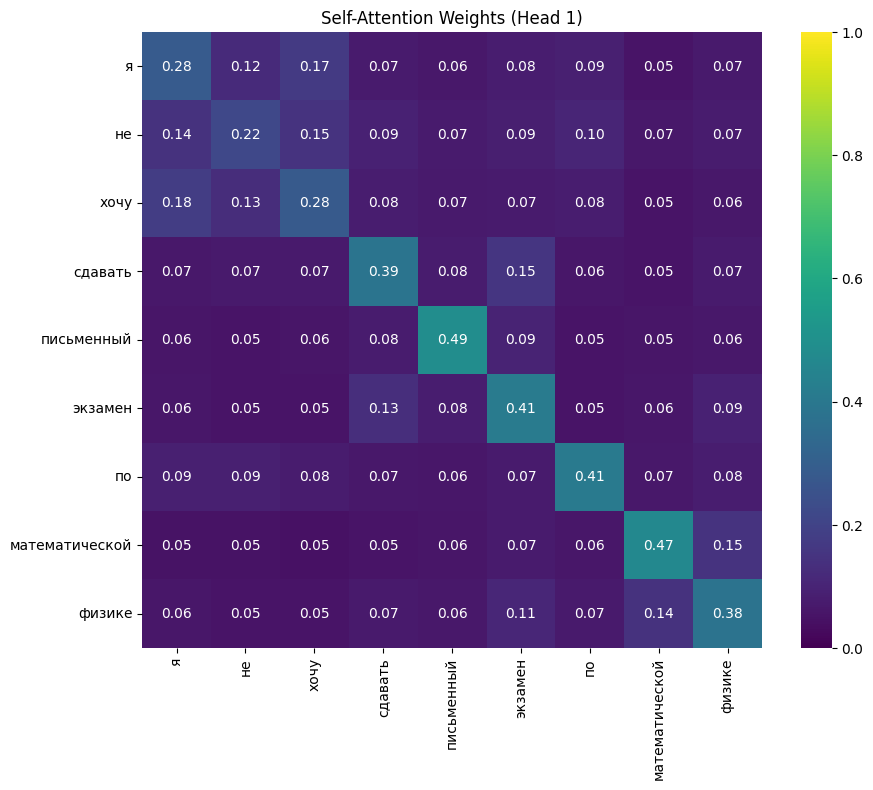

In [40]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.data.prepare_data import Data
from src.model.hparams import config
from src.model.scaled_dot_product_attention import ScaledDotProductAttention
from src.utils.shared_embedding import create_pretrained_embedding

# Инициализация данных
source_text = "Я не хочу сдавать письменный экзамен по математической физике."
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
verbose = True

# Загрузка предобученных эмбеддингов
embedding_path = str(Path(os.getcwd()).parent / "embeddings" / "navec_hudlit_v1_12B_500K_300d_100q.tar")
shared_embedding, embedding_model, pad_idx, unk_idx = create_pretrained_embedding(path=embedding_path)

data = Data(embedding_model)

# Инициализация словаря
data_path = str(Path(os.getcwd()).parent / "data" / "news.csv")
train_iter, test_iter = data.init_dataset(
    csv_path=data_path,
    batch_sizes=(config["train_batch_size"], config["test_batch_size"]),
    split_ratio=config["data_split_ratio"],
)

# Токенизация и числовое представление
tokenized = data.word_field.preprocess(source_text)
if verbose:
    print(f"Tokenized: {tokenized}")

vocab = data.word_field.vocab
numericalized = [vocab.stoi.get(token, unk_idx) for token in tokenized]
source_inputs = torch.tensor(numericalized, dtype=torch.long, device=device).unsqueeze(0)
source_mask = (source_inputs != unk_idx) & (source_inputs != pad_idx)
mask = source_mask

embedded_inputs = shared_embedding(source_inputs)

# Подготовка для multi-head attention
batch_size, seq_len, emb_dim = embedded_inputs.shape
num_heads = 2

query = key = value = embedded_inputs
query = query.unsqueeze(1).expand(-1, num_heads, -1, -1)
key = key.unsqueeze(1).expand(-1, num_heads, -1, -1)
value = value.unsqueeze(1).expand(-1, num_heads, -1, -1)

# Инициализация проекций
d_model = 300
num_heads = 2
head_dim = d_model // num_heads

print("Уникальные слова в предложении:", set(tokenized))
print("Есть ли OOV?:", [token for token in tokenized if token not in embedding_model])
print("Нормы эмбеддингов:", torch.norm(embedded_inputs, dim=-1))

print("source_mask:", source_mask)  # Должно быть True для всех токенов, кроме pad_idx

print("query shape:", query.shape)
print("key shape:", key.shape)
print("value shape:", value.shape)
print("mask shape:", mask.shape if mask is not None else "No mask")

# Attention
attention = ScaledDotProductAttention(dropout_rate=0.0)
attn_output, attn_weights = attention(query, key, value, mask=mask)

print("source_inputs:", source_inputs)  # Выведите source_inputs, чтобы увидеть индексы токенов
print("pad_idx:", pad_idx)  # Выведите pad_idx, чтобы убедиться, что он правильный
print("source_mask:", source_mask)  # Выведите source_mask (до расширения и инверсии)
print("mask:", mask)  # Выведите final mask

# Визуализация
first_head_weights = attn_weights[0, 0].detach().cpu().numpy()
tokens = tokenized
if len(tokens) < first_head_weights.shape[0]:
    first_head_weights = first_head_weights[: len(tokens), : len(tokens)]

plt.figure(figsize=(10, 8))
sns.heatmap(
    first_head_weights, annot=True, xticklabels=tokens, yticklabels=tokens, cmap="viridis", fmt=".2f", vmin=0, vmax=1
)
plt.title("Self-Attention Weights (Head 1)")
plt.show()